На основе ДИСЦИПЛИНАРНОГО РЕГЛАМЕНТА Российского футбольного союза (РФС) сделайте нейро-ассистента для ответов на вопросы по содержанию документа. Обратите внимание на разметку текста, используйте подходящий способ разделения на чанки. Выведите гистограммы распределения длин чанков. Получите ответы нейро-консультанта на представленной БЗ. Документ для БЗ можно получить по ссылке: "https://docs.google.com/document/d/1PGw2Y4PSJ2S7vfPlge9j6G_x0zX6jX4UEIitfwlP-c0/edit?usp=sharing"

In [1]:
!pip install -q langchain_openai==0.1.22 faiss-cpu==1.8.0 openai==1.55.3 tiktoken==0.7.0 langchain-core==0.2.33 langchain==0.2.14 langchain_community==0.2.12 langchain-text-splitters==0.2.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.6/389.6 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 391.5/391.5 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.8/997.8 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.8/311.8 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.9 MB/s eta 0:00:00


In [2]:
import requests
from langchain.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
import tiktoken
import matplotlib.pyplot as plt
import getpass
import os
import openai
from openai import OpenAI
from langchain.vectorstores import FAISS
import re
import getpass
from google.colab import userdata
from langchain_openai import ChatOpenAI
from langchain.text_splitter import RecursiveCharacterTextSplitter, MarkdownHeaderTextSplitter, CharacterTextSplitter
from langchain.docstore.document import Document

In [3]:
from google.colab import userdata

# Использование ключа API от ProxyAPI
key = userdata.get('PROXY_API_KEY')
os.environ["OPENAI_API_KEY"] = key

# Адрес сервера ProxyAPI
base_url = 'https://api.proxyapi.ru/openai/v1'
os.environ["OPENAI_BASE_URL"] = base_url

# Создание клиента OpenAI с использованием API ключа из переменных среды
client = OpenAI()

In [4]:
# функция для загрузки документа по ссылке из гугл драйв
def load_document_text(url: str) -> str:
    # Extract the document ID from the URL
    match_ = re.search('/document/d/([a-zA-Z0-9-_]+)', url)
    if match_ is None:
        raise ValueError('Invalid Google Docs URL')
    doc_id = match_.group(1)

    # Download the document as plain text
    response = requests.get(f'https://docs.google.com/document/d/{doc_id}/export?format=txt')
    response.raise_for_status()
    text = response.text

    return text

In [5]:
# База знаний, которая будет подаваться в langChain
data_from_url= load_document_text('https://docs.google.com/document/d/1PGw2Y4PSJ2S7vfPlge9j6G_x0zX6jX4UEIitfwlP-c0/edit?usp=sharing')

In [6]:
system = load_document_text('https://docs.google.com/document/d/1cZ7-cKflFH8YeSacRfATCwI_3uzdMnxJZvim0OmNnY0/edit?usp=sharing')

In [7]:
system

'\ufeffТы - консультант Российского Футбольного союза, ответь на вопрос сотрудника компании на основе документа с информацией о дисциплинарном регламенте. Не придумывай ничего от себя, отвечай максимально по документу. А также нельзя ссылаться в ответах на документы с информацией.'

In [8]:
def num_tokens_from_string(string: str, encoding_name: str) -> int:
      """Возвращает количество токенов в строке"""
      encoding = tiktoken.get_encoding(encoding_name)
      num_tokens = len(encoding.encode(string))
      return num_tokens

In [9]:
def split_text(text, max_count):
    headers_to_split_on = [
        ("#", "Header 1"),
        ("##", "Header 2"),
        ("###", "Header 3"),
    ]

    markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
    fragments = markdown_splitter.split_text(text)

    # Подсчет токенов для каждого фрагмента и построение графика
    fragment_token_counts = [num_tokens_from_string(fragment.page_content, "cl100k_base") for fragment in fragments]
    plt.hist(fragment_token_counts, bins=20, alpha=0.5, label='Fragments')
    plt.title('Distribution of Fragment Token Counts')
    plt.xlabel('Token Count')
    plt.ylabel('Frequency')
    plt.show()

    splitter = RecursiveCharacterTextSplitter(
        chunk_size=max_count,
        chunk_overlap=0,
        length_function=lambda x: num_tokens_from_string(x, "cl100k_base")
    )

    source_chunks = [
        Document(page_content=chunk, metadata=fragment.metadata)
        for fragment in fragments
        for chunk in splitter.split_text(fragment.page_content)
    ]

    # Подсчет токенов для каждого source_chunk и построение графика
    source_chunk_token_counts = [num_tokens_from_string(chunk.page_content, "cl100k_base") for chunk in source_chunks]
    plt.hist(source_chunk_token_counts, bins=20, alpha=0.5, label='Source Chunks')
    plt.title('Distribution of Source Chunk Token Counts')
    plt.xlabel('Token Count')
    plt.ylabel('Frequency')
    plt.show()

    return source_chunks

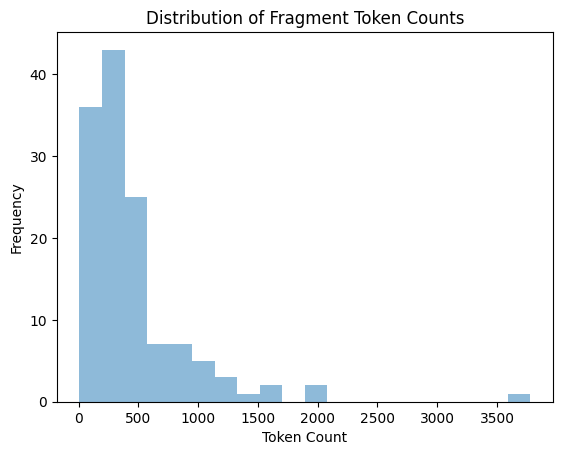

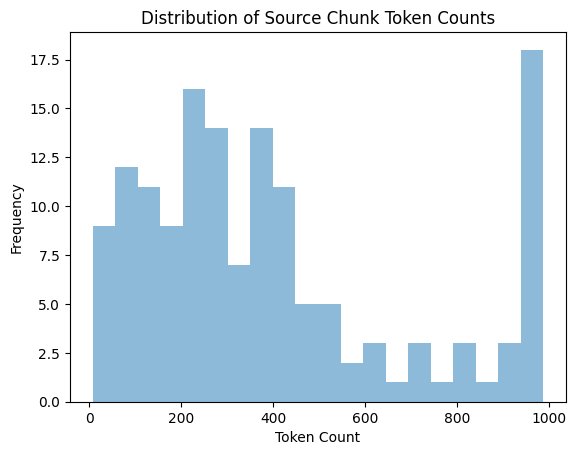

Общее количество чанков:  148


In [10]:
source_chunks = split_text(data_from_url, 1000)                          # заполните необходимыми значениями
print("Общее количество чанков: ",len(source_chunks))

In [11]:
# Инициализирум модель эмбеддингов
embeddings = OpenAIEmbeddings()

# Создадим индексную базу из разделенных фрагментов текста
db = FAISS.from_documents(source_chunks, embeddings)

In [12]:
# Функция, которая позволяет выводить ответ модели в удобочитаемом виде
def insert_newlines(text: str, max_len: int = 170) -> str:
    words = text.split()
    lines = []
    current_line = ""
    for word in words:
        if len(current_line + " " + word) > max_len:
            lines.append(current_line)
            current_line = ""
        current_line += " " + word
    lines.append(current_line)
    return " ".join(lines)

def answer_index(system, topic, search_index, temp=1, verbose=1):

    # Поиск релевантных отрезков из базы знаний
    docs = search_index.similarity_search(topic, k=5)
    if verbose: print('\n ===========================================: ')
    message_content = re.sub(r'\n{2}', ' ', '\n '.join([f'\nОтрывок документа №{i+1}\n=====================' + doc.page_content + '\n' for i, doc in enumerate(docs)]))
    if verbose: print('message_content :\n ======================================== \n', message_content)
    client = OpenAI()
    messages = [
        {"role": "system", "content": system},
        {"role": "user", "content": f"Ответь на вопрос сотрудника на основе представленной информации. Не упоминай документ с информацией для ответа сотруднику в ответе. Документ с информацией для ответа сотруднику: {message_content}\n\nВопрос сотрудника: \n{topic}"}        # заполните нужными значениями, проведите эксперименты
    ]

    if verbose: print('\n ===========================================: ')

    completion = client.chat.completions.create(
        model="gpt-4o-mini",                               # заполните нужным значением
        messages=messages,
        temperature=0.2                           # заполните нужными значениями, проведите эксперименты
    )
    answer = insert_newlines(completion.choices[0].message.content)
    return answer

Проверьте работу консультанта на самостоятельно сформулированных вопросах.

In [13]:
# вопрос пользователя
topic= "Кто такой зритель?"
ans=answer_index(system, topic, db)
ans


 ===========================================: 
message_content :
 
Отрывок документа №1
=====================1. Производство по делам, вытекающим из совершения дисциплинарных нарушений,
ведется на русском языке. Все документы предоставляются в Юрисдикционный орган на
26русском языке. Если документ предоставляется на иностранном языке, предоставившее
его лицо обязано также предоставить нотариально заверенный перевод документа.
2. Лицо, не владеющее русским языком, обязано привлечь для участия в заседании
Юрисдикционного органа переводчика.  
Отрывок документа №2
=====================ТРЕБОВАНИЙ РЕГЛАМЕНТА  
Отрывок документа №3
=====================Неправомерные действия зрителей, т.е. нарушения зрителями общественного
порядка, которые не подпадают под действие других норм настоящего Регламента, –
42наказывается штрафом в соответствии с пунктом 40 Приложения № 1 к настоящему
Регламенту, а в случае наступления серьезных последствий, – также запретом на допуск
зрителей в секторы стадиона 

' Зритель — это лицо, присутствующее на спортивном мероприятии, которое может быть подвергнуто дисциплинарным мерам в случае неправомерных действий, нарушающих  общественный порядок.'

In [14]:
# вопрос пользователя
topic= "Что такое предупреждение?"
ans=answer_index(system, topic, db)
ans


 ===========================================: 
message_content :
 
Отрывок документа №1
=====================1. Предупреждение является спортивной санкцией, которая применяется в
отношении Игрока/Официального лица клуба судьей до, во время и после матча в
соответствии с Правилами игры и выражается в предъявлении Игроку/Официальному
лицу клуба желтой карточки.
2. Два предупреждения, полученные Игроком/Официальным лицом клуба в ходе
одного матча, влекут за собой удаление и автоматическую дисквалификацию на
следующий матч.
3. В случае, если в настоящем Регламенте для применения спортивных санкций
имеет значение количество предупреждений, полученных одним либо несколькими
Игроками/Официальными лицами клуба, получение Игроком/Официальным лицом клуба
в течение одного матча двух предупреждений рассматривается как удаление и такие
предупреждения не учитываются при подсчете общего количества предупреждений. Если
Игрок/Официальное лицо клуба удален с поля за нарушение Правил игры, не связанное 

' Предупреждение является спортивной санкцией, которая применяется судьей к Игроку или Официальному лицу клуба до, во время и после матча. Оно выражается в предъявлении  желтой карточки. Предупреждение может быть применено за нарушения Правил игры. Если Игрок или Официальное лицо клуба получает два предупреждения в ходе одного матча, это  влечет за собой удаление и автоматическую дисквалификацию на следующий матч.'